# UNet Test

In [ ]:
from modules import *

In [ ]:
model = UNet(in_channels=1, out_channels=1, Transpose=True)

In [ ]:
model

In [ ]:
tensor_size = (1, 1, 572, 572)
test_tensor = torch.randn(tensor_size)
opt = model(test_tensor)

In [ ]:
test_tensor.size()

In [ ]:
opt.size()

# VAE Test

In [ ]:
from modules import *

model = VanillaVAE(
    in_channels=3,
    latent_dim=128
)


In [ ]:
model

In [ ]:
import torch
import torch.nn as nn

# Batch_size x Channels x Height x Width
tensor_size = (3, 3, 28, 28)
tensor = torch.randn(tensor_size)
print(tensor.size())

In [ ]:
mu, log_var = model.encode(tensor)
print(mu.size())
print(log_var.size())

In [ ]:
result = model.encode(tensor)
print(result.size())

In [ ]:
test = torch.flatten(result, start_dim=1)
print(test.size())

# DDPM Test

## Dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from sklearn.datasets import make_s_curve

s_curve, _ = make_s_curve(n_samples=10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]]/10.0  # shape of (10000, 2)

data = s_curve.T

fig, ax = plt.subplots()
ax.scatter(*data, color='black')

ax.axis('off')

dataset = torch.Tensor(s_curve).float()

In [ ]:
dataset.shape

In [ ]:
a= torch.randn((10000, 2))

In [ ]:
a.size()

## Hyperparameters

In [ ]:
import torch

num_steps = 100 # could estimate by beta, mu and sigma

betas = torch.linspace(-6, 6, num_steps)  # evenly spaced between -6 and 6
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5  # 1e-5 to 0.5e-2  where sigmoid opt 0 - 1

alphas = 1 - betas  
alphas_prod = torch.cumprod(alphas, dim=0)  # cumulative product
#alphas_prod_prev = torch.cat([torch.tensor([1.0]), alphas_prod[:-1]], 0)  # concatenate 1.0 at the beginning
alphas_bar_sqrt = torch.sqrt(alphas_prod)  
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)

assert alphas.shape==alphas_prod.shape==alphas_bar_sqrt.shape==one_minus_alphas_bar_sqrt.shape
print(betas.shape)

In [ ]:
import torch

x = torch.tensor([2, 2, 2, 2])
cp_x = torch.cumprod(x, dim=0)
print(cp_x)

## x_t in any t

In [ ]:
# Given x_0, t; Get any x_t using reparameterization trick
def q_x(x_0, t):
    noise = torch.randn_like(x_0)  # get from N(0,1)
    alpha_bar_t = alphas_bar_sqrt[t]  # get the aplha value at time t (sigma)
    alpha_1_m_t = one_minus_alphas_bar_sqrt[t]  
    return (alpha_bar_t * x_0 + alpha_1_m_t * noise)  # mu + sigma * epsilon

## Show the noising opt

In [ ]:
num_shows = 20
fig, axs = plt.subplots(2, 10, figsize=(28, 3))
plt.rc('text', color='blue')

for i in range(num_shows):
    j = i // 10
    k = i % 10

    q_i = q_x(dataset, torch.tensor([i*num_steps//num_shows]))  # Add i steps noise
    
    axs[j,k].scatter(q_i[:,0], q_i[:,1], color='black')
    axs[j,k].axis('off')

## Reverse Process

In [ ]:
import torch
import torch.nn as nn

class MLPDiffuser(nn.Module):
    def __init__(self, n_steps, num_units=128):
        super(MLPDiffuser, self).__init__()

        self.linears = nn.ModuleList(
            [
                nn.Linear(2, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, 2)
            ]
        )

        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
            ]
        )
    
    def forward(self, x_0, t):
        x = x_0
        for i, layer in enumerate(self.step_embeddings):
            t_embeddings = layer(t)
            x = self.linears[2*i](x)
            x += t_embeddings
            x = self.linears[2*i+1](x)
        
        x = self.linears[-1](x)
    
        return x

## Loss Function

In [ ]:
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    batch_size = x_0.shape[0]

    t = torch.randint(0, n_steps, size=(batch_size//2,))
    t = torch.cat([t, n_steps - t - 1], 0)
    t = t.unsqueeze(-1)

    a = alphas_bar_sqrt[t]

    am1 = one_minus_alphas_bar_sqrt[t]

    e = torch.randn_like(x_0)

    x = x_0 * a + am1 * e

    opt = model(x, t.squeeze(-1))

    return (e-opt).square().mean()

## Inference

In [ ]:
def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    t = torch.tensor([t])
    
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]

    eps_theta = model(x, t)

    mean = (1/(1-betas[t]).sqrt()) * (x - coeff * eps_theta)

    z = torch.randn_like(x)
    sigma_ = betas[t].sqrt()

    sample = mean + sigma_ * z

    return (sample)

def p_sample_loop(model, shape, num_steps, betas, one_minus_alphas_bar_sqrt):
    cur_x = torch.randn(shape)

    x_seq = [cur_x]
    for i in reversed(range(num_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)

        x_seq.append(cur_x)
    
    return x_seq

## Training

In [ ]:
batch_size= 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epoch = 4000

model = MLPDiffuser(num_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in range(num_epoch):
    for idx, batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    
    if (t%100 == 0):
        print(loss)
        

In [ ]:
x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt)

fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(1, 11):
    cur_x = x_seq[i * 10].detach()
    axs[i-1].scatter(cur_x[:,0], cur_x[:,1], color='black')
    axs[i-1].axis('off')

In [ ]:
torch.save(model, './MLPDiffuser.pt')

In [1]:
from ddpm import *

mlp_trainer = MLPDiffuserTrainer(
    num_steps = 100,
    num_epoch = 4000,
    gpu = True
)

In [ ]:
mlp_trainer.train()
mlp_trainer.save(
    path='./MLPDiffuser.pt'
)

In [2]:
mlp_trainer.load(
    path = './MLPDiffuser.pt'
)

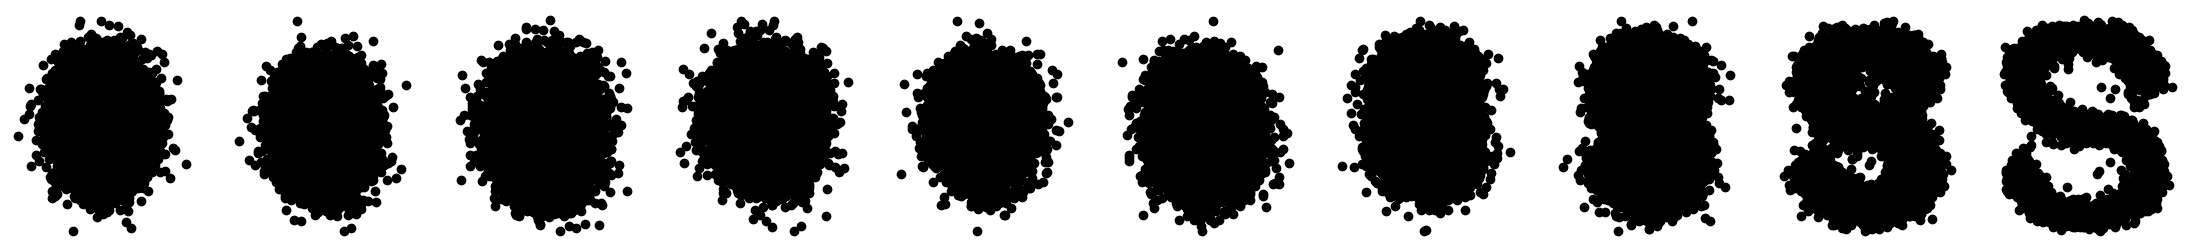

In [3]:
mlp_trainer.demo()